# Class 03 - Supplemental
## Using Categorical data in machine learning

Now that we've created some categorical data or other created features, we would like to use them as inputs for our machine learning algorithm. However, we need to tell the computer that the categorical data isn't the same as other numerical data. For example, I could have the following two types of categorical data:

1. Ordered Categorical Data: items like rankings or scales where the size of the output corresponds to some placement along a line. One example is the grade scale where A=4, B=3, C=2, D=1, F=0.
2. Unordered Categorical Data: Categories like gender, race, state, or color don't have any rational scale to place them on. So assigning red=4, blue=3 doesn't mean red is 'better' than blue.

We want to treat both of these slightly differently. We've got a sample dataset with both types of categorical data in it to work with. Our goal will be to predict the Output value.

In [1]:
import pandas as pd
import numpy as np

sampledata = pd.read_csv('Class03_supplemental_data.csv')

print(sampledata.dtypes)
sampledata.head()

Date       object
Rank       object
State      object
Output    float64
dtype: object


,Date,Rank,State,Output
0,2004-03-15T12:45:32Z,E,NH,211.813359
1,2004-03-15T20:50:02Z,F,MO,210.218858
2,2004-03-16T05:46:43Z,E,MT,210.915793
3,2004-03-16T22:19:24Z,D,LA,209.355303
4,2004-03-17T05:01:51Z,D,MD,205.653412


We can turn the date column into a real datetime object and get days since the first day in order to work with a more reasonable set of values.

In [2]:
sampledata["Date2"] = pd.to_datetime(sampledata["Date"])
firstdate = sampledata['Date2'][0]
sampledata['DaysSinceStart'] = sampledata['Date2'].apply(lambda date: ((date - firstdate ).seconds)/86400.0) # divided by the number of seconds in a day
sampledata.dtypes

Date                      object
Rank                      object
State                     object
Output                   float64
Date2             datetime64[ns]
DaysSinceStart           float64
dtype: object

## Ordered Categorical Values

The 'Rank' column are ranked categorical values where the ranking matters on a linear scale. So we can create a categorical column for these values right away. We are lucky here that the values are in alphabetical order - pandas can pick out that order and use it for us.

In [3]:
sampledata['CatRank'] = sampledata['Rank'].astype('category')
print(sampledata["CatRank"].cat.categories)
sampledata["CatRank"][1:10].cat.codes

Index(['A', 'B', 'C', 'D', 'E', 'F'], dtype='object')


1    5
2    4
3    3
4    3
5    4
6    2
7    1
8    1
9    2
dtype: int8

## Unordered Categorical Values

Let's now put the states into a categorical column. Even though Pandas will sort them, there is no real 'rank' for the states

In [4]:
sampledata['CatState'] = sampledata['State'].astype('category')
print(sampledata["CatState"].cat.categories)
sampledata["CatState"][1:10].cat.codes

Index(['AK', 'AL', 'AR', 'AZ', 'CA', 'CO', 'CT', 'DE', 'FL', 'GA', 'HI', 'IA',
       'ID', 'IL', 'IN', 'KS', 'KY', 'LA', 'MA', 'MD', 'ME', 'MI', 'MN', 'MO',
       'MS', 'MT', 'NC', 'ND', 'NE', 'NH', 'NJ', 'NM', 'NV', 'NY', 'OH', 'OK',
       'OR', 'PA', 'RI', 'SC', 'SD', 'TN', 'TX', 'UT', 'VA', 'VT', 'WA', 'WI',
       'WV', 'WY'],
      dtype='object')


1    23
2    25
3    17
4    19
5    20
6    16
7    23
8    45
9    38
dtype: int8

## Modeling with Categorical Data

Let's split the dataset and try modeling - we want to predict the output value. We need the categorical codes as columns to do this, so we'll take care of that part first.

In [5]:
sampledata['RankCode'] = sampledata['CatRank'].cat.codes
sampledata['StateCode'] = sampledata['CatState'].cat.codes
sampledata.columns

Index(['Date', 'Rank', 'State', 'Output', 'Date2', 'DaysSinceStart', 'CatRank',
       'CatState', 'RankCode', 'StateCode'],
      dtype='object')

In [6]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression

train1, test1 = train_test_split(sampledata, test_size=0.2, random_state=23)

# Step 1: Create linear regression object
regr1 = LinearRegression()

# Step 2: Train the model using the training sets
inputcolumns = ['DaysSinceStart','RankCode','StateCode']
features = train1[inputcolumns].values
labels = train1['Output'].values

regr1.fit(features,labels)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

RMS Error: 3.576


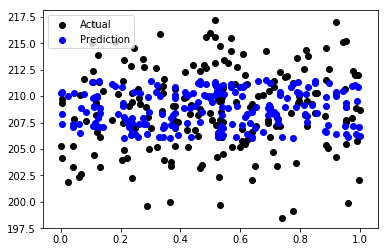

In [7]:
# Step 5: Get the predictions
testinputs = test1[inputcolumns].values
predictions = regr1.predict(testinputs)
actuals = test1['Output'].values

# Step 6: Plot the results
#
# Note the change here in how we plot the test inputs. We can only plot one variable, so we choose the first.
# Also, it no longer makes sense to plot the fit points as lines. They have more than one input, so we only visualize them as points.
#
import matplotlib.pyplot as plt
%matplotlib inline
plt.scatter(testinputs[:,0], actuals, color='black', label='Actual')
plt.scatter(testinputs[:,0], predictions, color='blue', label='Prediction')
plt.legend(loc='upper left', shadow=False, scatterpoints=1)

# Step 7: Get the RMS value
print("RMS Error: {0:.3f}".format( np.sqrt(np.mean((predictions - actuals) ** 2))))

So we see that this didn't do a very good job to start with. However, that's not surprising as it used the states as a ranked categorical value when they obviously aren't.


## Using Unranked categorical values

What we want is called a **dummy variable**. It will tell the machine learning algorithm to look at whether an entry is one of the states or not. Here's basically how it works. Suppose we have two categories: red and blue. Our categorical column may look like this:

| Row | Color |
|--- |---|
|0 | red |
| 1 | red |
| 2 | blue |
|3 | red |

What we want are two new columns that identify whether the row belongs in one of the categories. We'll use `1` when it belongs and `0` when it doesn't. This is what we get:

| Row | IsRed | IsBlue |
| --- | --- | ---|
| 0 | 1 | 0 |
| 1 | 1 | 0 |
| 2 | 0 | 1 | 
| 3 | 1 | 0 |


We now use these new dummy variable columns as the inputs: they are binary and will only have a 1 value where the original row matched up with the category column. Here's what it looks like in pandas.



In [8]:
dummydf = pd.get_dummies(sampledata['CatState'],prefix='S')
dummydf.head()

,S_AK,S_AL,S_AR,S_AZ,S_CA,S_CO,S_CT,S_DE,S_FL,S_GA,...,S_SD,S_TN,S_TX,S_UT,S_VA,S_VT,S_WA,S_WI,S_WV,S_WY
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


We now want to join this back with the original set of features so that we can use it instead of the ranked column of data. Here's one way to do that.

In [9]:
sampledata2 = sampledata.join(dummydf)
sampledata2.head()

,Date,Rank,State,Output,Date2,DaysSinceStart,CatRank,CatState,RankCode,StateCode,...,S_SD,S_TN,S_TX,S_UT,S_VA,S_VT,S_WA,S_WI,S_WV,S_WY
0,2004-03-15T12:45:32Z,E,NH,211.813359,2004-03-15 12:45:32,0.000000,E,NH,4,29,...,0,0,0,0,0,0,0,0,0,0
1,2004-03-15T20:50:02Z,F,MO,210.218858,2004-03-15 20:50:02,0.336458,F,MO,5,23,...,0,0,0,0,0,0,0,0,0,0
2,2004-03-16T05:46:43Z,E,MT,210.915793,2004-03-16 05:46:43,0.709155,E,MT,4,25,...,0,0,0,0,0,0,0,0,0,0
3,2004-03-16T22:19:24Z,D,LA,209.355303,2004-03-16 22:19:24,0.398519,D,LA,3,17,...,0,0,0,0,0,0,0,0,0,0
4,2004-03-17T05:01:51Z,D,MD,205.653412,2004-03-17 05:01:51,0.677998,D,MD,3,19,...,0,0,0,0,0,0,0,0,0,0


We now want to select out all 50 columns from the dummy variable. There is a python way to do this easily, since we used the prefix 'S\_' for each of those columns 

In [10]:
inputcolumns = ['DaysSinceStart','RankCode'] + [col for col in sampledata2.columns if 'S_' in col]

train2, test2 = train_test_split(sampledata2, test_size=0.2, random_state=23)

# Step 1: Create linear regression object
regr2= LinearRegression()

features = train2[inputcolumns].values
labels = train2['Output'].values

regr2.fit(features,labels)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

RMS Error: 1.438


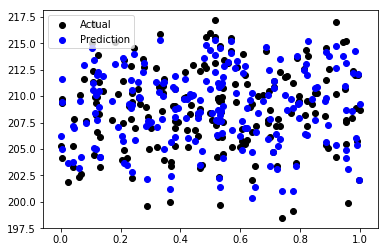

In [11]:
# Step 5: Get the predictions
testinputs = test2[inputcolumns].values
predictions = regr2.predict(testinputs)
actuals = test2['Output'].values

plt.scatter(testinputs[:,0], actuals, color='black', label='Actual')
plt.scatter(testinputs[:,0], predictions, color='blue', label='Prediction')
plt.legend(loc='upper left', shadow=False, scatterpoints=1)

# Step 7: Get the RMS value
print("RMS Error: {0:.3f}".format( np.sqrt(np.mean((predictions - actuals) ** 2))))

So, you can see we did significantly better by changing the categorical column into a dummy variable. Take a look at your own datasets to see if this is what you should be doing.